# **AM 207**: Homework 2

Verena Kaynig-Fittkau and Pavlos Protopapas  <br>
**Due: 11.59 P.M. Thursday March 3rd, 2015**

### Instructions:

+ Upload your answers in an ipython notebook to Canvas.

+ We will provide you imports for your ipython notebook. Please do not import additional libraries.

+ Your individual submissions should use the following filenames: AM207_YOURNAME_HW2.ipynb

+ Your code should be in code cells as part of your ipython notebook. Do not use a different language (or format). 

+ **Do not just send your code. The homework solutions should be in a report style. Be sure to add comments to your code as well as markdown cells where you describe your approach and discuss your results. **

+ Please submit your notebook in an executed status, so that we can see all the results you computed. However, we will still run your code and all cells should reproduce the output when executed. 

+ If you have multiple files (e.g. you've added code files or images) create a tarball for all files in a single file and name it: AM207_YOURNAME_HW2.tar.gz or AM207_YOURNAME_HW2.zip


### Have Fun!
_ _ _ _ _

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")

import time
import timeit

import scipy.stats 
import pandas as pd
import pymc as pm

import re
import numpy as np

# Problem 1: Geweke Convergence Test

In the lecture we have seen the Geweke test as one option to test for convergence of our metropolis hastings chain. Describe in your own words how the Geweke test works and its limitations. 

We provide you with the following code for the Geweke test. Write comments for the marked lines and any lines you think would be good to explain in addition. 

Write a short explanation of what the `rhot` function does and why it is necessary. 

In [313]:
#  Returns the covariance between subsections of a subtrace, where the sizes of these subsections are specified by t.
def rhot(x, t):
    n = len(x)
    return np.corrcoef(x[0:(n-t)], x[t:n])[0,1]

# The function accepts 3 inputs:
#   trace: a time-series of MC results that we are testing for convergence by comparing pairs of subtraces
#   intervals: the number of pairs of intervals that we want to compare
#   length: the length of each of the subtrace that is compared
def Geweke(trace, intervals, length):
    nsl=length
    # Jump is the size of the 'bags', or subtraces that we will compare.  This size is set to give the specified 
    #    number of intervals.
    jump = int(0.9*len(trace)/(2*intervals))
    # The second bag will start after the first 10% of the data (burn-in period).
    first = 0.1*len(trace)
    
    z =np.empty(intervals)
    # We will fill the z array with z-scores for the subtrace comparisons.  
    for k in np.arange(0, intervals):
        # This is the index of the of the first 'bag' in the time-series that we are comparing, starting after the 
        #    first 10% of the data.  
        baga = np.int(first+k*jump)
        # This is the index of the second 'bag' that we are comparing, starting at the second half of the data.  
        bagb = len(trace)/2 + k*jump
        
        # We take each subtrace, starting at the index we defined above, of the length that was passed into the 
        #    function.  
        sub_trace_a = trace[baga:baga+nsl]
        sub_trace_b = trace[bagb:bagb+nsl]
        
        # The thetas are the means of each subtrace.  These are used to calculate the t-statistics that are 
        #    returned for each pair.  
        theta_a = np.mean(sub_trace_a)
        theta_b = np.mean(sub_trace_b)
        rho_a, rho_b = 1.0, 1.0
        #   Use the rhot function to create quantities that we use to correct the variance for autocorrelation
        for i in xrange(int(0.1*nsl)):
            # 
            rho_a += 2*rhot(sub_trace_a, i+1)
            rho_b += 2*rhot(sub_trace_b, i+1)
            
        # The variance of the subtraces, corrected for autocorrelation and the length of the subtraces.  
        var_a  = np.var(sub_trace_a)*rho_a/length
        var_b  = np.var(sub_trace_b)*rho_b/length
        
        # Append the z-statistic for the comparison of these two subtraces
        z[k] = (theta_a-theta_b)/np.sqrt( var_a + var_b)
    
    return z


# Problem 2: Message Response Times

The file `hangout_chat_data.csv` contains the response times of your friend Mark to google hangout chat messages in seconds. Use a method of your choice to read the file into a data frame or a numpy array. Your goal for this problem is to model Mark's chat response time distribution in a Bayesian framework. 

The description of the data sounds like a Poisson distribution is a good choice for our likelihood. We have messages arriving independently of each other, and instead of the arrival time we consider the time it took Mark to respond to the messages. 

* Load and describe the data by plotting a histogram of the response times. 
* Derive and compute the maximum likelihood solution for a Poisson distribution.
* Compare this to the Bayesian solution with a prior of your choice and using your own implementation of Metropolis Hastings to sample from the posterior. Make sure to describe why you chose this prior, as well as the specifics of your Metropolis Hastings implementation. 

* Analyze your sampling using traceplots and convergence tests. You can use the Geweke implementation given above. 
* Compare your solution to a solution using the MCMC class in pymc and write a brief discussion. Which parameters does your implementation need that the pymc implementation can do without? How do the traceplots compare? 

* Check your ML solution and the Bayesian solution against the data. If you know how you can use the posterior predictive for the Bayesian solution, otherwise you can use the MAP estimate or the expectation value of the posterior and compare that distribution to the data histogram. 

* Was our model a good choice for this problem? If yes great, if not, come up with a different Bayesian model that is better capable of capturing the data and show that it works better. 


In [3]:
times = np.loadtxt('hangout_chat_data.csv')

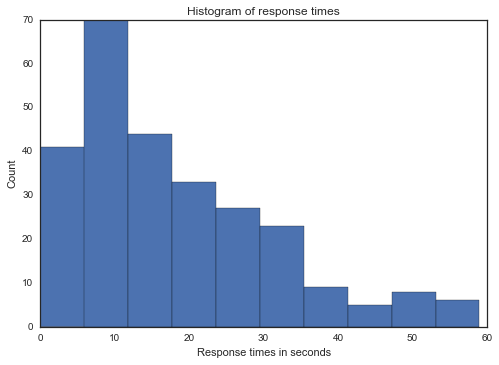

In [5]:
plt.hist(times)
plt.title("Histogram of response times")
plt.ylabel("Count")
plt.xlabel("Response times in seconds");

To derive the maximum-likelihood solution for a Poisson distribution, we can set the log-likelihood of the distribution to zero and solve for lambda.  

The distribution is written as follows:
\begin{equation}
f(x_1, ..., x_n | \lambda) = \frac{e^{-\lambda} \lambda^{x_1}}{x_1!}...\frac{e^{-\lambda}\lambda^{x_n}}{x_n!} = \frac{e^{-n \lambda} \lambda^{\sum(x_i)}}{x_1! ... x_n!}
\end{equation}

Taking the log of both sides:
\begin{equation}
\ln(f) = -n \lambda + (\ln \lambda) \sum x_i - \ln(\prod x_i !)
\end{equation}

Take the derivative and set to zero:
\begin{equation}
\frac{d (\ln f)}{\lambda} = -n + \frac{\sum x_i}{\lambda} = 0
\end{equation}

Solving for $\lambda$, we get:
\begin{equation}
\lambda = \frac{\sum x_i}{n}
\end{equation}

Which is simply the mean of the values of the data set.
* from http://mathworld.wolfram.com/MaximumLikelihood.html

In [418]:
# Maximum Likelihood for Lambda is:
mle_lamb = np.mean(times)
print mle_lamb

18.0413533835


Given that I don't know anything about the distribution of Mark's text response time, I pick the uninformative prior (Jeffrey's prior), which for the Poisson distribution is $\sqrt(\frac{1}{\lambda})$ (https://en.wikipedia.org/wiki/Jeffreys_prior)

The posterior is the prior ($\sqrt(\frac{1}{\lambda})$) multiplied by the likelihood ($\frac{e^{-n \lambda} \lambda^{\sum(x_i)}}{x_1! ... x_n!}$), which is simply the product of the Poisson probability density for each $x_i$.

However, the denominator of this term is very large and causes the likelihood becomes numerically unstable.  Therefore I take the log-likelihood and ignore the $\prod x_i$ term, which does not depend on $\lambda$.

This leaves me with $-n \lambda + (ln \lambda) \sum_i x_i$ as the log-likelihood terms that I include in my posterior

In [281]:
# I use the log of the posterior, which is the sum of the log of the prior and the log of the likelihood.
def calc_posterior(lamb, x=times):
    return np.log(np.sqrt(1./lamb)) + (-len(x)*lamb + np.log(lamb)*sum(x))


In [371]:
## Adapted from lecture 8
rnorm = np.random.normal
runif = np.random.rand

def metropolis(n_iterations, initial_value, prop_std=0.5, doPrint=True):
    #################################################################
    # function to sample using Metropolis 
    # (assumes proposal distribution is symmetric)
    # 
    # n_iterations:  number of iterations
    # initial_values: multidimensional start position for our chain
    # prop_std: standard deviation for Gaussian proposal distribution 
    ##################################################################
    
            
    # Initial proposal standard deviation
    std_l = prop_std
    
    # Initialize trace for lambda values
    trace = np.empty(n_iterations+1)
    
    # Set initial value equal to that which was passed in to the function.
    trace[0] = initial_value
        
    # Calculate joint posterior for initial value using the modified log- posterior defined above
    current_prob = calc_posterior(trace[0])
    
    # Initialize acceptance counts
    # We can use this to tune our step size
    accepted = 0
    
    for i in range(n_iterations):
    
        if not i%10000 and doPrint: 
            print 'Iterations left: ', n_iterations-i
    
        # Grab current lambda value
        current_lambda = trace[i]
    
        # Get current value for lambda
        p = trace[i].copy() 

        # proposed new value
        prop_lamb = rnorm(current_lambda, std_l)

        # Insert new value 
        p = prop_lamb

        # Calculate posterior with proposed value
        proposed_prob = calc_posterior(p)

        # Log-acceptance rate
        alpha = proposed_prob - current_prob

        # Sample a uniform random variate
        u = runif()

        # Test proposed value
        # Here I take the log of the random uniform value to match the log posteriors
        if (np.log(u)) < alpha:
            # Accept
            trace[i+1] = prop_lamb
            current_prob = proposed_prob
            accepted += 1
        else:
            # Stay put
            trace[i+1] = trace[i]

        # update p so we search the next dimension according
        # to the current result
        p = trace[i+1]

    # return our samples and the number of accepted steps
    return trace, accepted

To test the function, I run it with a nonsensical starting lambda of 100.  

In [372]:
tr, ac = metropolis(10000, 100)

Iterations left:  10000


From this trace plot, it looks like the algorithm converged quickly. 

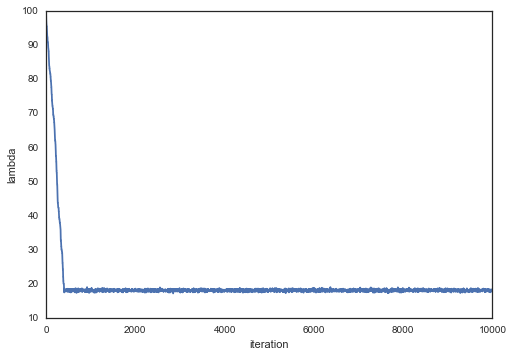

In [374]:
plt.plot(tr)
plt.ylabel("lambda")
plt.xlabel("iteration");

From multiple overlain trace plots with random starting lambdas, it can be seen that the algorithm converges quickly, no matter what the starting value is.

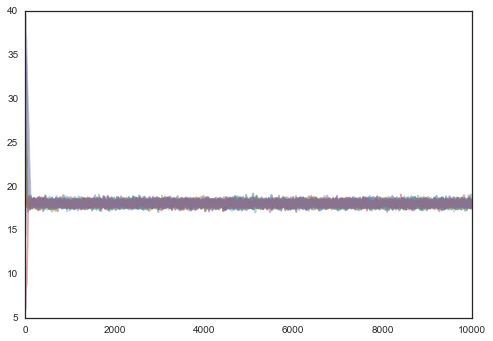

In [375]:
for i in range(10):
    tr,ac = metropolis(10000, np.random.uniform(low=1, high=40), doPrint=False)
    plt.plot(tr, alpha = 0.5)

In [389]:
tr,ac = metropolis(10000, np.random.uniform(low=1, high=40), doPrint=False)

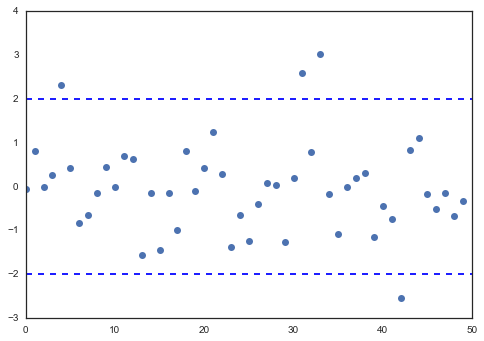

In [398]:
z = scores = Geweke(tr, 50, 100)
plt.plot(z, 'o')
plt.hlines([2,-2], 0, 50, 'blue', linestyle='dashed')
# pm.Matplot.geweke_plot(pm.geweke(tr, first=0.1, last=0.5, intervals=20), "alpha")
# pm.Matplot.geweke_plot( , "alpha"

The Geweke diagnostic shows that the bulk of the z-scores are within 2 standard deviations of the mean, and there is no trend in the data.  It looks like the data has clearly converged.  

A histogram of the trace shows that the lambda values are centered at the MLE estimate.  

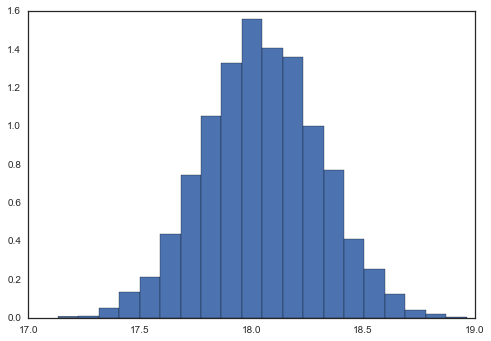

In [411]:
plt.hist(tr[500:],bins=20,normed=True);

Now with PyMC

In [849]:
lambd = pm.Normal('lambd', mu=0, tau=2)


@pm.deterministic 
def prior(l=lambd):
    return 1./np.sqrt(l)

responsetimes = pm.Poisson('responsetimes', prior, value=times, observed=True)

rt_model=pm.Model([prior, lambd, responsetimes])
mcmc = pm.MCMC(rt_model)
mcmc.sample(iter=10000, burn=0)

 [-----------------100%-----------------] 10000 of 10000 complete in 0.6 sec

In [850]:
mcmc.summary()


prior:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	17.838           1.321            0.126          [ 14.533  19.096]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	14.533           17.811          18.048         18.321        19.096
	

lambd:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.004            0.011            0.0              [ 0.003  0.005]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.003            0.003           0.003          0.003         0.005
	


In [851]:
mcmc.stats()

{'lambd': {'95% HPD interval': array([ 0.00274223,  0.00473454]),
  'mc error': 0.00035307168852458202,
  'mean': 0.0035037212565141138,
  'n': 10000,
  'quantiles': {2.5: 0.0027422316072865851,
   25: 0.0029793581020908541,
   50: 0.0030700051121585548,
   75: 0.0031522999105429612,
   97.5: 0.0047345435319912192},
  'standard deviation': 0.011252168821531012},
 'prior': {'95% HPD interval': array([ 14.53318972,  19.09624306]),
  'mc error': 0.1256311384395295,
  'mean': 17.837655164903381,
  'n': 10000,
  'quantiles': {2.5: 14.533189719828227,
   25: 17.810915169220305,
   50: 18.048056865320955,
   75: 18.320555884481909,
   97.5: 19.096243062917566},
  'standard deviation': 1.3213354534112158}}

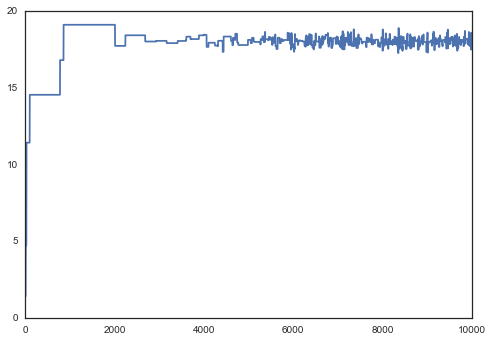

In [852]:
plt.plot(prior.trace())

It appears that the pymc implementation actually converges more slowly, but it does reach the same value of 18.  

A plot of the Poisson with lambda set to the average of the coded M-H trace after a burn-in of 500 iterations shows that the Poisson distribution does not fit the data well.  

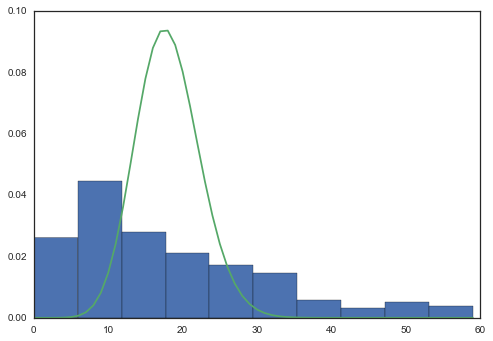

In [853]:
plt.hist(times,normed=True)
plt.plot(scipy.stats.poisson.pmf(range(0,60),mu=np.mean(tr[500:])));

A better model might be the negative binomial distribution.  

In [869]:
# The hyperparameters mu and alpha are drawn from a uniform distribution
# After trying an initial smaller range, I saw that the mu selected kept being on the upper end of its range, 
#    so I adjusted this range to allow for mu to be higher.  
mu = pm.Uniform('mu', 0,50)
alpha = pm.Uniform('alpha', 0,10)


# Here I implement Jeffrey's prior for the negative binomial, corrected for the difference in parameterization.  
# Found the Jeffrey's prior here: http://stats.stackexchange.com/questions/58099/neg-binomial-and-the-jeffreys-prior
@pm.deterministic
def prior(m=mu, a=alpha, value=0):
    thet = a/(a+m)
    return mu/((1-thet)*thet**2)

def posterior_negbinom(x, samples=10000):
    likelihood=pm.NegativeBinomial("observation", mu, alpha, value=times, observed=True)
    mcmc = pm.MCMC(pm.Model([prior, likelihood, mu, alpha]))
    mcmc.sample(iter=samples)
    return mcmc

test=posterior_negbinom(times)

 [-----------------100%-----------------] 10000 of 10000 complete in 1.9 sec

In [870]:
test.stats()

{'alpha': {'95% HPD interval': array([ 1.6034478 ,  2.28771804]),
  'mc error': 0.010070591849427246,
  'mean': 1.9160836320159353,
  'n': 10000,
  'quantiles': {2.5: 1.603447804799657,
   25: 1.7889241011729282,
   50: 1.891445877392264,
   75: 2.026753572493813,
   97.5: 2.2924545398759184},
  'standard deviation': 0.20659581120016729},
 'mu': {'95% HPD interval': array([ 16.57069488,  19.83455434]),
  'mc error': 0.026497951843569796,
  'mean': 18.11017604634705,
  'n': 10000,
  'quantiles': {2.5: 16.520113846486613,
   25: 17.557680114559538,
   50: 18.077347200909653,
   75: 18.628135147564866,
   97.5: 19.826661875942957},
  'standard deviation': 0.83507173517377742},
 'prior': {'95% HPD interval': array([ 1492.34781919,  2993.85218808]),
  'mc error': 18.72032648823085,
  'mean': 2173.918923335666,
  'n': 10000,
  'quantiles': {2.5: 1508.456183185418,
   25: 1899.2374180065049,
   50: 2147.912066926719,
   75: 2420.829158371736,
   97.5: 3029.919922173633},
  'standard deviation

In [871]:
# I pull the parameter values out from the stats.  
alpha = test.stats()['alpha']['mean']
mu = test.stats()['mu']['mean']

In [872]:
print alpha, mu

1.91608363202 18.1101760463


In [873]:
# Transform parameters to scipy's form
n=alpha
p=alpha/(alpha+mu)

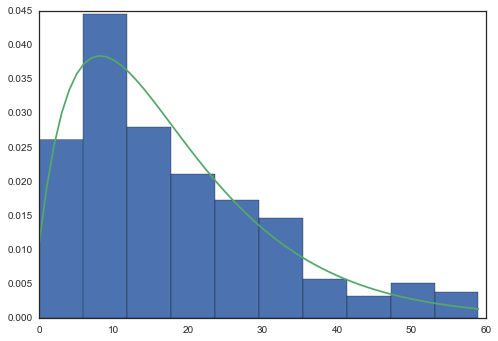

In [874]:
plt.hist(times,normed=True)
plt.plot(scipy.stats.nbinom.pmf(range(60),n,p))

### This distribution fits the data much better!

# Problem 3: Markov Chains

* Given the following transition matrix, examine if the corresponding Markov Chain is irreducible and aperiodic. Note: No formal proof necessary, but you should give a solid argumentation.

$$ P = \left( 
\begin{array}{ccccc}
0.0 & 0.4 & 0.6 & 0.0 & 0.0 \\
0.65 & 0.0 & 0.35 & 0.0 & 0.0 \\
0.32 & 0.68 & 0.0 & 0.0 & 0.0 \\
0.0 & 0.0 & 0.0 & 0.12 & 0.88 \\
0.0 & 0.0 & 0.0 & 0.56 & 0.44 
\end{array}
\right ) $$



### This transition matrix is not irreducible because it is impossible to transition from states 1, 2, or 3 to states 4 or 5, and vice versa-- these transition probabilities are 0.  
### This matrix describes two distinct graphs.  States 1, 2, and 3 can only transition among themselves (and each state can not stay in its own state), and states 4 and 5 can both transition among themselves and stay in their own states.  
### The 4-5 graph is clearly aperiodic because the states can both transition between each other and stay the same, so there is no regular period.  
### The 1,2,3 graph is also aperiodic because, although each of the individual states cannot stay in their own states, they can transfer to either of the other two, and so there is no regular period.

# Problem 4: The Evidence 

In lectures we mostly concentrate on the likelihood and the prior and regard the evidence as a mere normalization factor. However, the evidence can be quite useful. In this problem you will compare different models by computing the evidence for each model, aka the probability that randomly selected parameters from a given model class would generate the data $X$.

As our models we compare polynomials of degree 0 to 4. For example for degree 2 we have $y = a_0 + a_1 \cdot x + a_2 \cdot x^2 + \epsilon$ where $\epsilon \sim N(0, \sigma) $ and $\theta = [a_0, a_1, a_2, \sigma]$. Assume that for all polynomials $a_i \sim \text{Expo}(1)$ and $\sigma \sim \text{Inverse Gamma}(1,1)$.


Bayes' theorem states that:
$$
P(\theta|x)=\frac{P(x|\theta)P(\theta)}{P(x)}
$$
$P(\theta)$ is the prior, $P(x|\theta)$ is the likelihood, $P(x)$ is called the evidence, and $P(\theta|x)$ is the posterior.

Your tasks are:

* Write down the mathematical equation of the evidence in terms of the likelihood and the prior. You don't need to solve the integral analytically, just write down its formula.
* Now you have the evidence in the form of an integral. Solve it by using importance sampling. What is a good choice for your importance sampling distribution?
* Compare the evidence for polynomials of degree 0 to 4. Which polynomial wins?

In [632]:
# Here is your data for the problem:
data = np.array([[ -1.85519254,  -2.7009541 ],
       [  4.38291824,  19.61735369],
       [  2.29495208,   3.96481822],
       [  0.02075668,   8.00646088],
       [  0.54097177,   2.8872262 ]])

x=data[:,0]
y=data[:,1]

The evidence can be written: $P(x) = \int P(\theta)P(x|\theta)d\theta$

So we have that $\theta = [a_0, a_1, a_2, a_3, a_4, \sigma]$.  
A good choice for the importance sampling distribution is to draw $a_i$ from Expo(1) and $\sigma$ from InvGamma(1,1).  Here, we don't need to correct for a normalization constant because the integral of both of these distributions is 1, so these are convenient.  

The integral can be approximated as $\frac{1}{N}\sum_{i=1}^N P(x|\theta)$, and here $P(x|\theta)$ is given from the normal pdf $Normal(E[y],\sigma)$, where $E[y]$ is the value of $y = a_0 + a_1 x + ... + \epsilon$ where $\epsilon=0$.  

In [709]:
start=time.time()

no_tries = 10
no_samples = 10000

def y_expected(x, theta):
    # Returns expected value of y, ie value of y given a_ values, when epsilon is zero
    return np.sum([theta[i]*(x**i) for i in range(len(theta))])

# I store the results in a dictionary
results = {}
# Over the range of specified polynomial orders:
for m in range(6):
    # Store the integral values calculcated for each try
    integrals = np.zeros(no_tries)

    for j in range(no_tries):
        # For each sampling of parameters, calculate p(x|theta) and collect it into samples
        samples = np.zeros(no_samples)
        
        # Create an array of the a_i coefficients, drawn randomly from the Exp(1) distribution
        theta = np.vstack([scipy.stats.expon.rvs(loc=0, scale=1, size=no_samples) for _ in range(m+1)]).T
        
        # Draw sigma from the InvGamma(1,1) distribution
        sig = scipy.stats.invgamma.rvs(1,1, size=no_samples)
        
        # Store the Expectation values for each data point given the polynomial coefficients
        y_hats=np.zeros((no_samples,len(y)))
        for k in range(no_samples): 
            y_hats[k,:]=[y_expected(x_i, theta[k,:]) for x_i in x]
            
        # Now we calculate a log-likelihood value over all the data points for each sample of hyperparameters.
        # This is calculated by summing the probalities of the observed y given the data and the hyperparameters,
        #    in other words is the pdf value from the Normal distribution centered at the Expectation value of y
        #    with the standard deviation specified by the sigma hyperparameter.  
        samples = np.sum(np.vstack([scipy.stats.norm.pdf(y[i]*np.ones(no_samples), 
                                                        y_hats[:,i], sig) for i in range(len(y))]),axis=0)
        
        # Our estimate of the integral for each try is the mean of the likelihoods
        integrals[j] = np.mean(samples)
    
    # Put the results into a dictionary that includes the estimated integral value, and the error of the estimate
    results['Degree '+str(m)]={'Mean':"{0:.4f}".format(np.mean(integrals)), 'Std':"{0:.4f}".format(np.std(integrals))}

print "{0:.1f}".format(time.time()-start), "seconds to run"

35.5 seconds to run


In [714]:
estimates = []
errorbars = []
for k in results:
    print k, " Estimate: ", results[k]['Mean'], ", Error: ", results[k]['Std']
    estimates.append(float(results[k]['Mean']))
    errorbars.append(float(results[k]['Std']))

Degree 0  Estimate:  0.2073 , Error:  0.0008
Degree 1  Estimate:  0.3090 , Error:  0.0016
Degree 2  Estimate:  0.2588 , Error:  0.0011
Degree 3  Estimate:  0.2122 , Error:  0.0010
Degree 4  Estimate:  0.1640 , Error:  0.0008
Degree 5  Estimate:  0.1579 , Error:  0.0006


## So the Degree 1 polynomial has the highest evidence.  

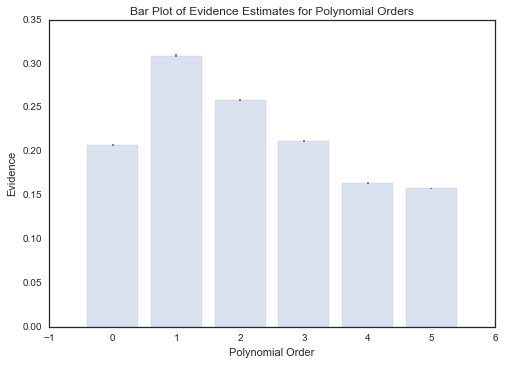

In [722]:
plt.bar(left = np.arange(6)-0.4, height=estimates, yerr=errorbars, alpha=0.2)
plt.ylabel("Evidence")
plt.xlabel("Polynomial Order")
plt.title("Bar Plot of Evidence Estimates for Polynomial Orders");

# Problem 5: Which YouTube Videos to Watch

Youtube videos have a like and an unlike flag. We can use these up and down votes on the videos to determine if a video is worth watching. However, it is not immediately obvious how to rank a video with just 3 up and 0 down rankings against a video with 300 up and 100 down votes. We will address this problem using a Bayesian approach.

Build two Bayesian models for the average upvote rate of a video. Both models should use the same likelihood, but different priors. Use one prior where people in general are rather undecided about videos, and one where people tend to be very opinionated. Compare the resulting posteriors for each video. How does the different choice of prior change your results? 

Given that there are so many videos on YouTube we want a really conservative way to decide if it is worth watching. Compute the 5th percentile for the posterior of each video and rank the videos according to this value. Is the 5th percentile a good indicator for the ranking? What are the benefits, what are potential drawbacks?

In [463]:
# Here is the [upvote, downvote] data for 4 different videos:
video_votes = np.array([[3,0],[300,100],[2,2],[200,100]])

The likelihood of this situation is Binomial($n$,$\pi$), where $n$ is the total number of viewers and $\pi$ is the fraction of people who rated the video positively.  The Beta distribution is a conjugate prior for the binomial, so the posterior will also be binomial.  

For the prior where people are rather undecided about the videos, we could model this with a Beta distribution with $\alpha$=1 and $\beta$=1.  This is a uniform distribution, so there is no certainty about what the true popularity is.  

For the prior where people are very opinionated, most of the probability mass will be at 0 and 1.  This can be accomplished with a Beta distribution with $\alpha$=0.5 and $\beta$=0.5.  

The conjugate prior is convenient in this case, because the posterior is simply the Beta distribution with $\alpha'$=$\alpha$ + $y$, and $\beta'$=$\beta$+$n$-$y$ where $y$ is the number of people who rated the video down, and is equal to $n\pi$.

In [468]:
priors = [[1,1],[0.5,0.5]]

In [469]:
def posteriors(priors, votes):
    indecisive = []
    opinionated = []
    for video in list(votes):
        indecisive.append(priors[0]+video)
        opinionated.append(priors[1]+video)
    return indecisive, opinionated

In [471]:
ind, opi = posteriors(priors,video_votes)

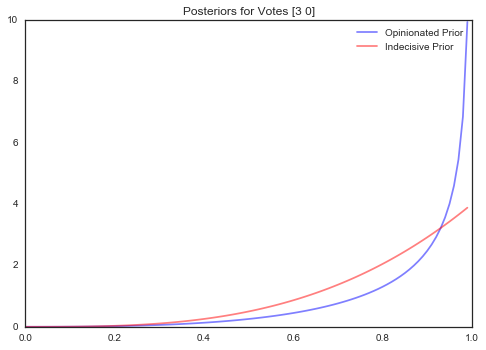

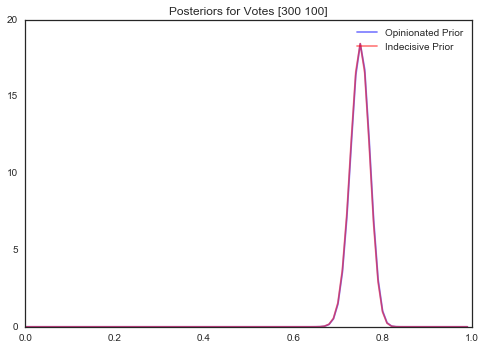

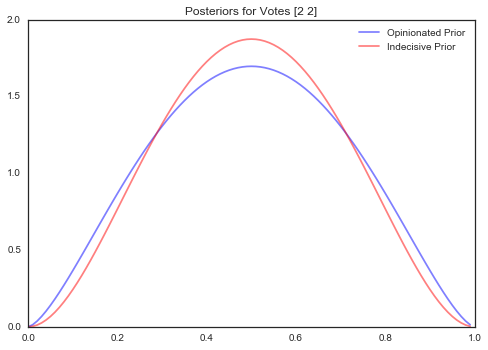

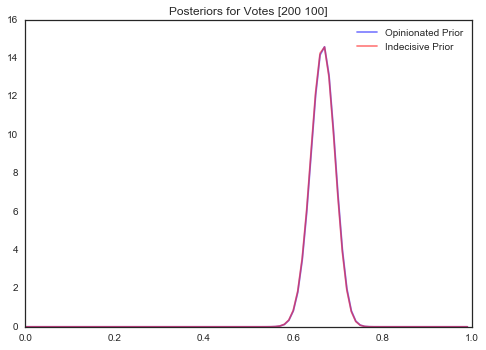

In [493]:
ran = np.arange(0,1,0.01)
for i in range(len(video_votes)):
    plt.plot(ran,scipy.stats.beta.pdf(ran,opi[i][0],opi[i][1]),color='blue',alpha=0.5,label="Opinionated Prior")
    plt.plot(ran,scipy.stats.beta.pdf(ran,ind[i][0],ind[i][1]),color='red',alpha=0.5,label="Indecisive Prior")
    plt.title("Posteriors for Votes "+str(video_votes[i]))
    plt.legend()
    plt.show()

This shows that, for a large number of observations, the prior has very little effect because it is overpowered by the data.  In the plots, we see that the distributions overlap and are nearly identical.  

In contrast, where there are few observations, the opinionated prior puts much more probability mass at the extremes of the distribution.  For example, in the [3,0] case, with the opinionated prior, the posterior is very certain that the probability value is close to 1, while with the indecisive prior, the probability value is still fairly widely spread.  The balanced [2,2] case also shows that the opinionated prior is less peaked than with the indecisive prior, which keeps probability mass near the center.  

In [508]:
for i in range(len(video_votes)):
    samples_ind = np.random.beta(ind[i][0],ind[i][1],10000)
    samples_opi = np.random.beta(opi[i][0],opi[i][1],10000)
    
    print "5th %ile of {} with Indecisive prior: {:.2}".format(video_votes[i],np.percentile(samples_ind, 5))
    print "5th %ile of {} with Opinionated prior: {:.2}".format(video_votes[i],np.percentile(samples_opi, 5))

5th %ile of [3 0] with Indecisive prior: 0.47
5th %ile of [3 0] with Opinionated prior: 0.56
5th %ile of [300 100] with Indecisive prior: 0.71
5th %ile of [300 100] with Opinionated prior: 0.71
5th %ile of [2 2] with Indecisive prior: 0.19
5th %ile of [2 2] with Opinionated prior: 0.16
5th %ile of [200 100] with Indecisive prior: 0.62
5th %ile of [200 100] with Opinionated prior: 0.62


The 5th percentile is not a very useful indicator because it doesn't tell us anything about the shape of the distribution of our idea about how good the video might be.  For example, the 5th percentile for [200 100] (0.62) is close to the 5th percentile for [3 0] (0.56), but in reality we are much more certain about the quality of the [200 100] video, as can be seen by the tightness of its distribution.  